# Determinação de parâmetros usando o algorítmo genético *stochastic differential evolution* e o modelo compartimental SEIAR

In [1]:
# basic modules
import numpy as np
import matplotlib.pylab as plt
from scipy.special import erf
import pandas as pd
from scipy.integrate import odeint

## Colleita de series temporais do repositorio da Johns Hopkins University

In [128]:
raw_deaths    = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
raw_confirmed = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
raw_recovered = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

confirmed = pd.read_csv(raw_confirmed)
deaths    = pd.read_csv(raw_deaths)
recovered = pd.read_csv(raw_recovered)

time = confirmed.columns[4:]
def get_timeseries(country):
  cc = confirmed[confirmed['Country/Region']==country].iloc[:,4:].values
  dd = deaths[deaths['Country/Region']==country].iloc[:,4:].values
  rr = recovered[recovered['Country/Region']==country].iloc[:,4:].values
  return np.array([cc[0,:],dd[0,:],rr[0,:]])

In [129]:
Brazil = get_timeseries('Brazil')
Brazil_days = np.arange(0,len(Brazil[0,:]))

## SEIAR model

O sistema de equações a ser resolvido consideira 6 compartimentos

* $S$: População susceptível
* $E$: População exposta
* $I$: População infectada
* $A$: População infectada asimptomatica
* $R$: População recuperada
* $D$: Número de óbitos

As equações que são resolvidas são:

\begin{eqnarray}
\frac{d S}{dt} &=& - \frac{\beta}{N}SI - \frac{\mu \beta}{N}SA - \theta \frac{mS}{N-I} +  \theta \frac{nS}{N-I} \\ 
\frac{d E}{dt} &=& \frac{\beta}{N}SI + \frac{\mu \beta}{N}SA -E/Z -  \theta \frac{mE}{N-I} + \theta \frac{nE}{N-I}   \\ 
\frac{d I}{dt} &=&  \alpha \frac{E}{Z} - \frac{I}{D} - \gamma I  \\ 
\frac{d A}{dt} &=& (1-\alpha)  \frac{E}{Z}  -\frac{A}{D} - \theta \frac{mA}{N-I} +  \theta \frac{nA}{N-A}   \\ 
\frac{d R}{dt} &=& \frac{I}{D} + {\bf \frac{A}{D}} - mR \\
\frac{d D}{dt} &=& \gamma I\\
\end{eqnarray}

Na analise a seguir não será considerada mobilidade, logo os termos $\theta$, $m$ e $n$ são iguais a zero. O termo em 'boldface', $\frac{A}{D}$,  na equação para $R$,  não é considerado pois esse termpo considera recuperação de pacientes asimptomáticos.  Não precisamos remove-los deste compartimento se queremos encontrar os parâmetros usando $I$, $D$ e $R$ como grandezas a ser usadas na optimização.

### Parâmetros a ser determinados:

Utilizamos os seguintes limítes para os parâmetros:

* $N = (10.e6 - 100.e6)$: número de pessõas susceptíveis
* $\beta = (0.5 - 2.5) $: taxa de transmisão [1/dias]
* $\gamma = (0.01 - 0.1) $: taxa de fatalidade [1/dias] 
* $\mu = (0.1 - 0.9 )$: a transmião devido a asimptomaticos é diminuida por esse fator
* $\theta = 0$ : fator multiplicativo por mobilidade 
* $\alpha = (0.01 - 0.6)$: fração de infeções documentadas
* $Z = (2 - 5)$: período de latencia [dias]
* $D = (2 - 10) $: duração da infeção [dias]
* $m = 0$: taxa de saida de pessoas da amostra
* $n = 0$: taxa de entrada de pessoas na amostra

As equações são definidas na função `sirf_func`, ela é chamada pela função `sird`. 


In [4]:
def sird_func(x, t, *args):
    
    S,E,I,A,R,D = x
    N, beta, gamma, mu, theta, Z, D, alpha, m, n = args
    
    dSdt = -beta*S*I/N - mu*beta*S*A/N  + theta*m*S/(N-I) - theta*n*S/(N-I)
    dEdt =  beta*S*I/N + mu*beta*S*A/N - E/Z - theta*m*E/(N-I) + theta*n*S/(N-I)
    dIdt =  alpha*E/Z - I/D - gamma*I
    dAdt =  (1.-alpha)*E/Z - A/D - theta*m*A/(N-I) 
    dRdt =  I/(D) # + A/(D) - m*R
    dDdt =  gamma*I
    
    return dSdt,dEdt,dIdt,dAdt,dRdt,dDdt

In [5]:
def sird(args,tmin=0,tmax=120):
    
    N, beta, gamma, mu, theta, Z, D, alpha, m, n = args

    nt = (tmax-tmin)      # time steps    
    t = np.linspace(tmin,tmax,nt)
    
    # Initial conditions
    
    x0 = N, 20., 1., 6., 0., 0.
    sol = odeint(sird_func,x0,t,args=(N, beta, gamma, mu, theta, Z, D, alpha, m, n))
    Re = alpha*beta*D + (1.-alpha)*mu*beta*D
        
    return sol[:,0], sol[:,1], sol[:,2], sol[:,3], sol[:,4],sol[:,5], Re, t

## Função custo RMS 

Comparamos número de infectados, óbitos assim como recuperados.

In [6]:
# Root mean square error
def rmse(args,estado=Brazil):
    tmin = 35
    tmax = len(estado[0,:])
    y = estado
    s, e, i, a, r, d, R0, t = sird(args,tmin,tmax)
    SdI = sum((y[0,int(tmin):] - i)**2) / len(y[0,int(tmin):])
    SdD = sum((y[1,int(tmin):] - d)**2) / len(y[1,int(tmin):])
    SdR = sum((y[2,int(tmin):] - r)**2) / len(y[2,int(tmin):])
    return np.sqrt(SdI+SdD+SdR)

In [120]:
N = (10.e6,100.e6)
beta = (0.5,2.5)
gamma = (0.01,0.1)
mu = (0.1,0.9)
theta = (0.,0.)
Z = (2.,5.)
D = (2.,10.)
alpha = (0.01,0.6)
m = (0.,0.)
n = (0.,0.)

## A optimização é feita pelo algorítmo de evolução diferencial estocástica

São feitas 100 optimizações

In [121]:
from scipy.optimize import differential_evolution
import time
import multiprocessing
from joblib import Parallel, delayed

x = []
tStart = time.time()
for i in range(100):
    bounds = [N,beta,gamma,mu,theta,Z,D,alpha,m,n]
    results = differential_evolution(rmse,bounds,tol=1e-3,strategy='rand1bin',polish=True)
    if i%10 == 0:
        print('iteration #',i, 'beta = ',results.x[1])
    x.append(results.x)
tStop = time.time()-tStart
print(tStop)

iteration # 0 beta =  1.12928465745
iteration # 10 beta =  0.96119033841
iteration # 20 beta =  1.34793446073
iteration # 30 beta =  1.15322446913
iteration # 40 beta =  1.71739223503
iteration # 50 beta =  0.974895017184
iteration # 60 beta =  1.09241935077
iteration # 70 beta =  1.03747262709
iteration # 80 beta =  0.852723654921
iteration # 90 beta =  1.32771768677
8340.70152926445


In [123]:
x= np.array(x)

## Valor estimado dos parâmetros, média sob as 100 saidas com desviação estándard

In [125]:
N = x[:,0].mean()
beta=x[:,1].mean()
gamma = x[:,2].mean()
mu=x[:,3].mean()
theta = x[:,4].mean()
Z= x[:,5].mean()
D=x[:,6].mean()
alpha=x[:,7].mean()
m=x[:,8].mean()
n=x[:,9].mean()
args_mean = N, beta, gamma, mu, theta, Z, D, alpha, m, n
sO, eO, iO, aO, rO, dO, R0, t = sird(args_mean,tmin,420)
print(R0)

7.09772591279


In [132]:
print('Polulation, N =',N, '+/-',x[:,0].std())
print('tranmission, beta =',beta, '+/-',x[:,1].std())
print('fatality, gamma =',gamma, '+/-',x[:,2].std())
print('transmission non-documented, nu =',mu,'+/-',x[:,3].std() )
print('latency, Z=',Z, '+/-',x[:,5].std())
print('duration, D=',D, '+/-',x[:,6].std())
print('fraction of documented infections, alpha =',alpha, '+/-',x[:,7].std())
print('R0 = $', alpha*beta*D+(1.-alpha)*mu*beta*D)


Polulation, N = 25276221.52 +/- 18764699.9927
tranmission, beta = 1.19377971323 +/- 0.212015706781
fatality, gamma = 0.01 +/- 1.73472347598e-18
transmission non-documented, nu = 0.554803007233 +/- 0.116282566467
latency, Z= 3.79112087158 +/- 0.70746775604
duration, D= 9.99999922367 +/- 7.72441918641e-06
fraction of documented infections, alpha = 0.0893001054623 +/- 0.00932604675621
R0 = $ 7.09772591279


## Representação gráfica dos resultados

<IPython.core.display.Javascript object>


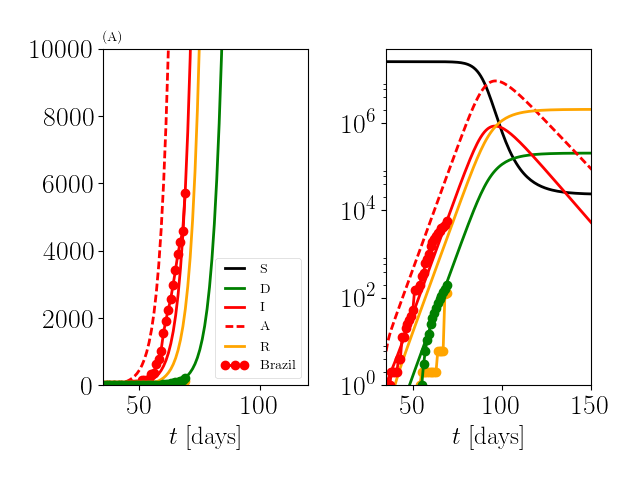

In [131]:
%matplotlib notebook


fig, ax = plt.subplots(1,2)
ax[0].set_title('(A) ',fontsize=10,loc='left')
ax[0].plot(t,sO,label='S',c='k')
ax[0].plot(t,dO,label='D',c='g')
ax[0].plot(t,iO,label='I', c='r')
ax[0].plot(t,aO,label='A',c='r',linestyle='--')
ax[0].plot(t,rO,label='R',c='orange')
ax[0].plot(Brazil_days,Brazil[0,:],'-o',label='Brazil', color='r')
ax[0].plot(Brazil_days,Brazil[2,:],'-o', color='orange')
ax[0].plot(Brazil_days,Brazil[1,:],'-o', color='green')

ax[0].set_xlabel(r'$t$ [days]')
xmin=35
xmax=120
ymin = 0
ymax = 1e4
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)
plt.yscale('log')
ax[0].legend(fontsize=10)

ax[1].plot(t,sO,label='S',c='k')
ax[1].plot(t,dO,label='D',c='g')
ax[1].plot(t,iO,label='I', c='r')
ax[1].plot(t,aO,label='A',c='r',linestyle='--')
ax[1].plot(t,rO,label='R',c='orange')
ax[1].plot(Brazil_days,Brazil[0,:],'-o',label='BH', color='r')
ax[1].plot(Brazil_days,Brazil[2,:],'-o', color='orange')
ax[1].plot(Brazil_days,Brazil[1,:],'-o', color='green')

ymin=1e0
ymax=5e7
xmin=35
xmax=150
ax[1].set_ylim(ymin,ymax)
ax[1].set_xlim(xmin,xmax)

ax[1].set_xlabel(r'$t$ [days]')
plt.tight_layout()

## Resultados

Seguem algumas considerações sobre os resultados obtidos.

* O parâmetro de transmisão $\beta =  1.1 \pm 0.2$ concorda com o estimado por Li et al. (2020).
* Taxa de transmisão relativa $\nu =  0.55 \pm 0.1$ bate também com o estimado no mesmo trabalho.
* A fração de infetados documentados corresponde ao 9% dos casos.
* Com esses valores a tendência de população infetada concorda com os números reportados. 
* Importante notar que o número inicial de pessoas susceptíveis foi permitido de encontrar valores entre 10 e 100 milhões de pessoas. Isto porque não é realista pensar que toda a população brasileira foi exposta durante esses primeiros dias de pandemia. O valor médio encontrado é de ~25 milhões, porém com uma desviação de $\pm$ 18 milhoes. 
* O ajuste de fatalidades bate com o reportado, sendo uma taxa de 1% dos infetados.  A taxa pode ser ainda menor, pois praticamente todas as 100 simulações apontaram ao limite inferior. 
* Não há ajuste no número de pessoas recuperadas. Ao tentar ajustar esse parâmetro o algorítmo ajusta ao valor máximo (10 dias) em todas as simulações. Já o perído de latencia converge a um valor compatível com o encontrado na literatura recente. 
* Nota-se que a tendência nos casos confirmados estava mudando. No entanto retomou o mesmo caminho inicial.


